#### Introduction

##### &emsp;Reviews are a wonderful tool for gauging a company's performance from the eyes of their customer(s). These short snippets of text also provide immense meaning and context to other potential customers. There is so much information available to buyers, it is almost a conscious decision to NOT be an informed consumer. The hospitality industry experiences make or break moments with these reviews and social media posts and bad interactions are broadcast further and faster than ever. The pandemic did serious damage to all industries, but maybe none more than hospitality. Any assistance to keep the customers happy (and returning) will ultimately help speed up the recovery of the industry. The digital age has presented a unique opportunity for companies to interact with their customers on a more personal level and if taken advantage of, can have direct effect on bottom lines.
##### &emsp;Hotel reviews also present a unique opportunity for training natural language processing (NLP) tasks because the one responsible for writing the review is the one who labels the data - with their 'star' rating. With the exponentially increasing use of social media, SMS text messages, and chats, companies now have massive amounts of raw text data to process, and, unlike reviews, these sources do not come with pre-labeled ratings. The application of training from these pre-labeled datasets can then be applied back to the un-labeled sources to help these companies flag the issues that need dealt with the most, and quickest, to limit the backlash it could cause. Chats can be flagged and sent to escalation departments before ever being answered by a live agent. Social media posts can be logged and reported if rectification is warranted in the situation.
##### &emsp;In this analysis, I will be training models to classify the rating (score of 1-5) of the hotel review by the contents of its text. The reviews were obtained through labelled datasets available on Kaggle. To start, I will train the model with reviews from only one source using readily available models such as BERT and GPT-3 and see how it performs on the labelled reviews from another source. If the model can generalize across different sources, we can infer it will generalize well no matter the source of text (chat, web, blog, social media, etc.). I will also train a model based on the combination of all sources to compare its performance. If the second model performs better, we can infer the model(s) need as many different sources as possible to be effective regardless of source.


In [18]:
## Data manipulation
import pandas as pd
import numpy as np

## Visualizations
from wordcloud import WordCloud
from folium import Map
from folium.plugins import HeatMap

## Text pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

## Models
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.svm import LinearSVC as lsvc
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
## Load csv to data frame
review_df_1 = pd.read_csv('Datafiniti_Hotel_Reviews.csv')
review_df_2 = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv').drop(['reviews.dateAdded'], axis=1)

## Reviews from a different site to test model fitness
other_review_df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [3]:
review_df = pd.concat([review_df_1, review_df_2]).drop(['id', 'reviews.dateSeen', 'dateAdded', 'dateUpdated', 'reviews.sourceURLs', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sourceURLs', 'websites', 'categories', 'primaryCategories', 'address', 'keys'], axis=1).drop_duplicates()
review_df

,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.rating,reviews.text,reviews.title
0,Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2013-11-14T00:00:00Z,5.0,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!
1,Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2014-07-06T00:00:00Z,5.0,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity
2,Rancho Santa Fe,US,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2015-01-02T00:00:00Z,5.0,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience
3,Hanover,US,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2016-05-15T00:00:00Z,2.0,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep."
4,Hanover,US,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2016-07-09T00:00:00Z,5.0,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...
...,...,...,...,...,...,...,...,...,...,...,...
9995,Hampton,US,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,2015-12-24T00:00:00Z,4.0,My friends and I took a trip to Hampton for th...,Very accommodating and friendly staff!
9996,Hampton,US,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,2015-11-17T00:00:00Z,5.0,"from check in to departure, staff is friendly,...","comfortable, friendly, clean, professional"
9997,Hampton,US,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,2016-07-06T00:00:00Z,5.0,This Hampton is located on a quiet street acro...,Great location
9998,Hunter,US,42.210915,-74.215309,Roseberry's Inn,12442,NY,2016-10-26T00:00:00.000Z,5.0,Awesome wings (my favorite was garlic parmesan...,Great Atmosphere!


In [4]:
## Round reviews to the nearest whole number for classification and force to categorical dtype
review_df['reviews.rating'] = review_df['reviews.rating'].apply(lambda x: round(x))
review_df['reviews.rating'] = pd.Categorical(review_df['reviews.rating'])

other_review_df['Rating'] = other_review_df['Rating'].apply(lambda x: round(x))
other_review_df['Rating'] = pd.Categorical(other_review_df['Rating'])

## Add year column to data frame
review_df['year'] = review_df['reviews.date'].str[0:4].astype(int)

In [5]:
## Heat map for reviews by location
for_map = Map(location=[30.169621, -96.683617], zoom_start=4)
hm_wide = HeatMap(list(zip(review_df['latitude'].values, review_df['longitude'].values)), min_opacity=0.2, radius=18, blur=15, max_zoom=1)
for_map.add_child(hm_wide)

This heat map shows the distribution of the reviews across the United States. Will hotel location have any affect on the classification model - do different words have different weights based on where the location?

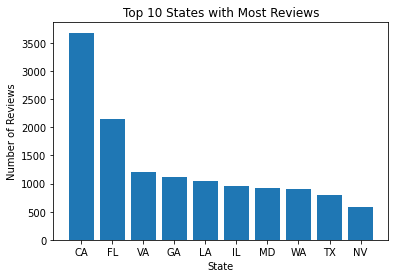

In [6]:
## Histogram with top 10 states by review numbers
grouped_df = review_df[['reviews.rating', 'province']].groupby(['province']).count().reset_index().nlargest(10, 'reviews.rating')
plt.bar(list(grouped_df['province']), list(grouped_df['reviews.rating']))
plt.title('Top 10 States with Most Reviews')
plt.xlabel('State')
plt.ylabel('Number of Reviews')
plt.show()

There are significantly more reviews from California hotels than any other state.

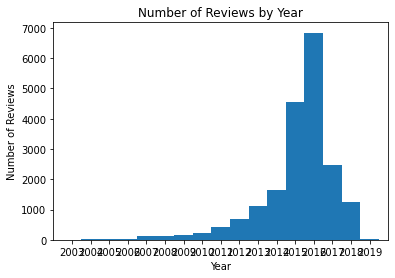

In [7]:
## Histogram showing distribution of review counts by year
fig, ax = plt.subplots()
plt.hist(review_df['year'],align='left', bins=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
ax.set(xticks=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], xlim=[2002,2020])
plt.rcParams['figure.figsize'] = (30,10)
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Year')
plt.show()

The majority of the reviews come from 2015-2017. Since language gradually changes over time, these reviews are recent enough to still be applicable to today.

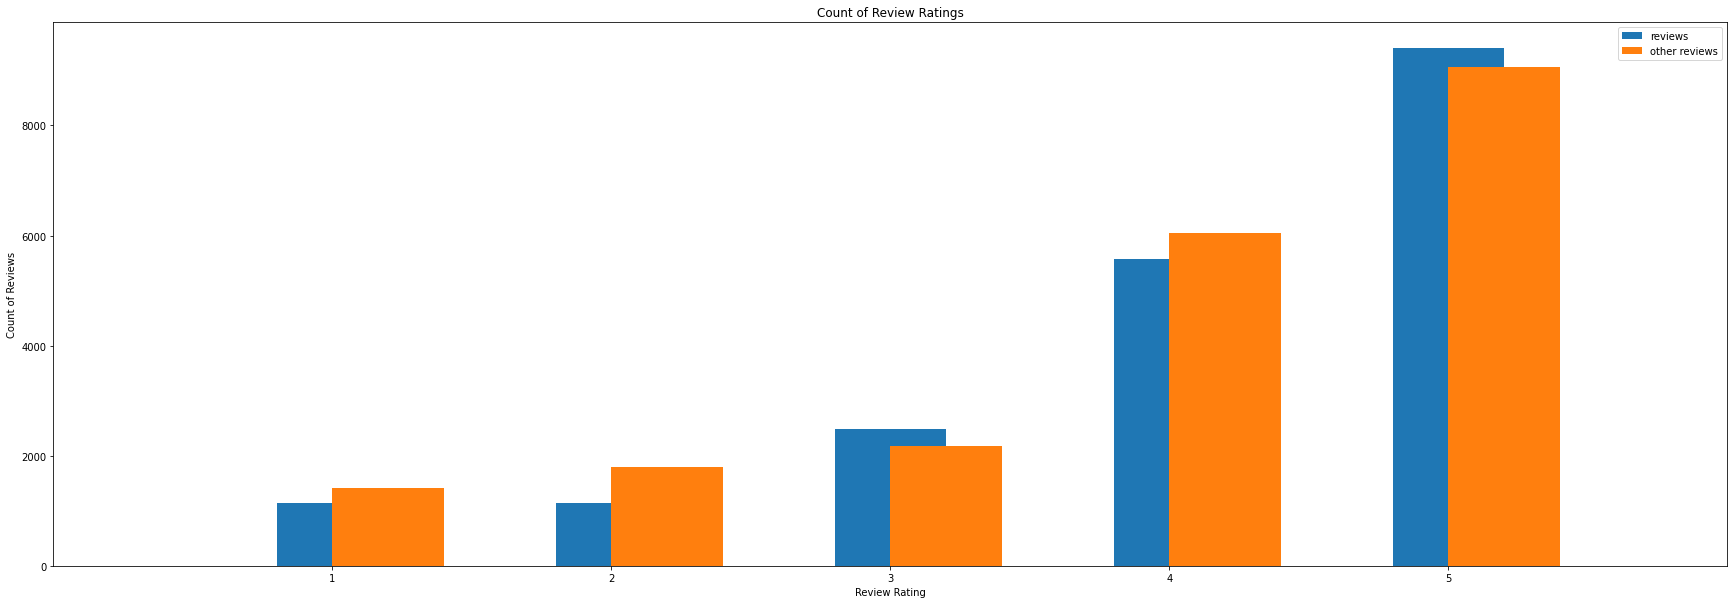

In [8]:
## Histogram showing distribution of review counts by rating
fig, ax = plt.subplots()
ax.bar(range(6), np.bincount(review_df['reviews.rating']), width=0.4, align='center', label='reviews')
ax.bar(range(6), np.bincount(other_review_df['Rating']), width=0.4, align='edge', label='other reviews')
ax.set(xticks=[1,2,3,4,5], xlim=[0,6])
plt.title('Count of Review Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Count of Reviews')
plt.legend()
plt.show()

As we can see from the histogram, we have significantly more 'good' reviews (4 or 5) than 'bad' reviews (1 or 2) in both datasets. It will be necessary to filter the dataset before training the model to ensure it is not better at classifying good reviews than bad reviews. It may also be advantageous to bin the ratings into a binary category of good versus bad. (1 for a rating of 4 or more, 0 for less than 4)

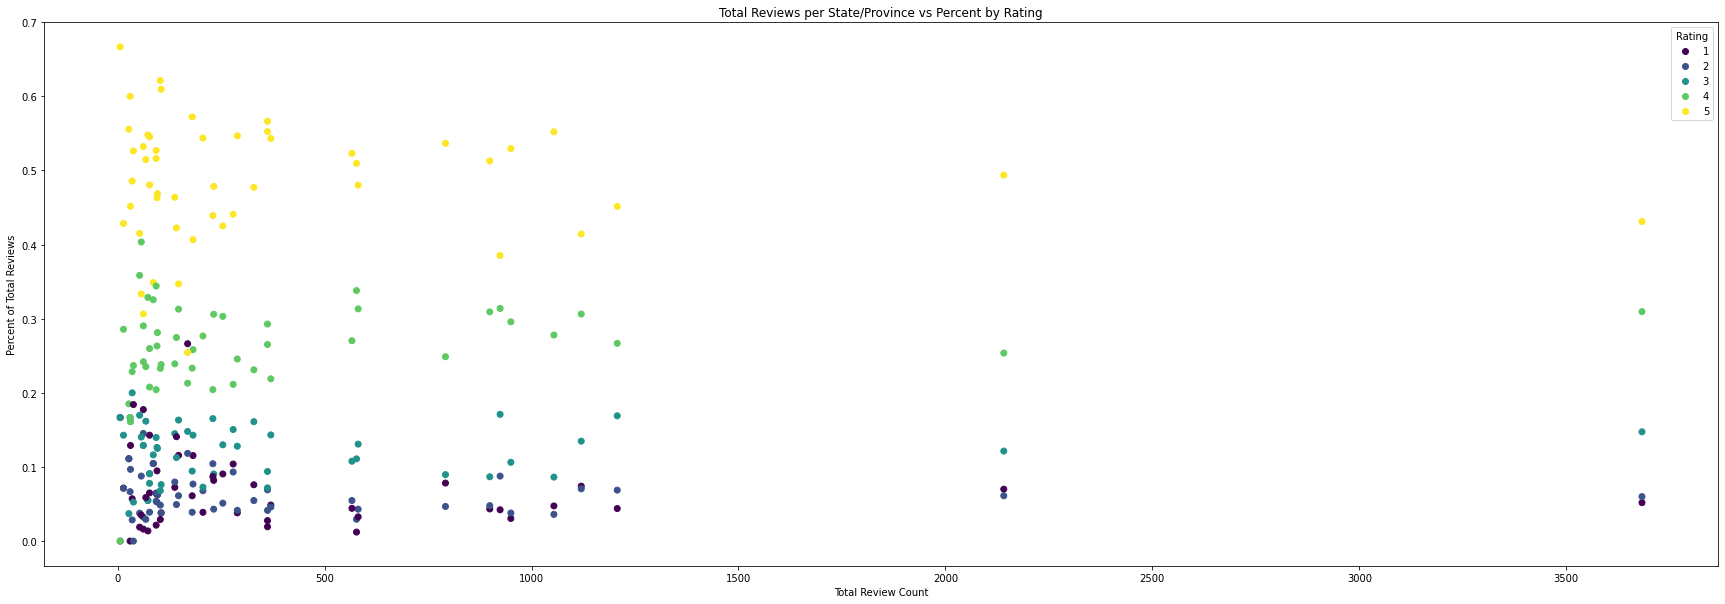

In [9]:
## Scatter plot showing relationship between total number of reviews and percent of each rating
grouped_df = review_df[['reviews.rating', 'province']].groupby(['province', 'reviews.rating']).size().reset_index().merge(review_df[['reviews.rating', 'province']].groupby(['province']).count().reset_index(), how='left', left_on='province', right_on='province').set_axis(['province', 'rating', 'rating_count', 'total_count'], axis=1, inplace=False)
grouped_df['pct_reviews'] = grouped_df['rating_count'] / grouped_df['total_count']
labels = ['1','2','3','4','5']
scatter = plt.scatter(grouped_df['total_count'], grouped_df['pct_reviews'], c=grouped_df['rating'])
plt.legend(handles=scatter.legend_elements()[0], labels=labels, bbox_to_anchor=(1, 1), loc='upper right', ncol=1, title='Rating')
plt.xlabel('Total Review Count')
plt.ylabel('Percent of Total Reviews')
plt.title('Total Reviews per State/Province vs Percent by Rating')
plt.show()

This scatter plot shows the distribution of the percent of each review rating is mostly standard across all states, regardless of the total number of reviews.

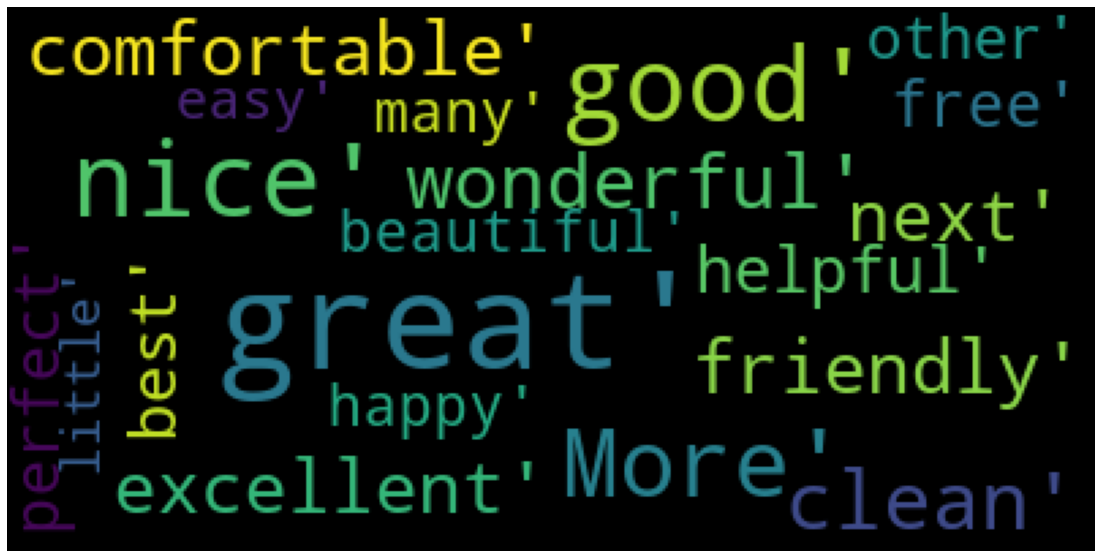

In [10]:
 ## Word cloud showing most used adjectives in 5 star reviews
text = str([word for word,tag in nltk.pos_tag(nltk.word_tokenize(pd.Series(review_df.loc[review_df['reviews.rating'] == 5, 'reviews.text']).str.cat(sep=' ')), tagset='universal') if tag == 'ADJ'])

wordcloud = WordCloud(max_words=20, max_font_size=50, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

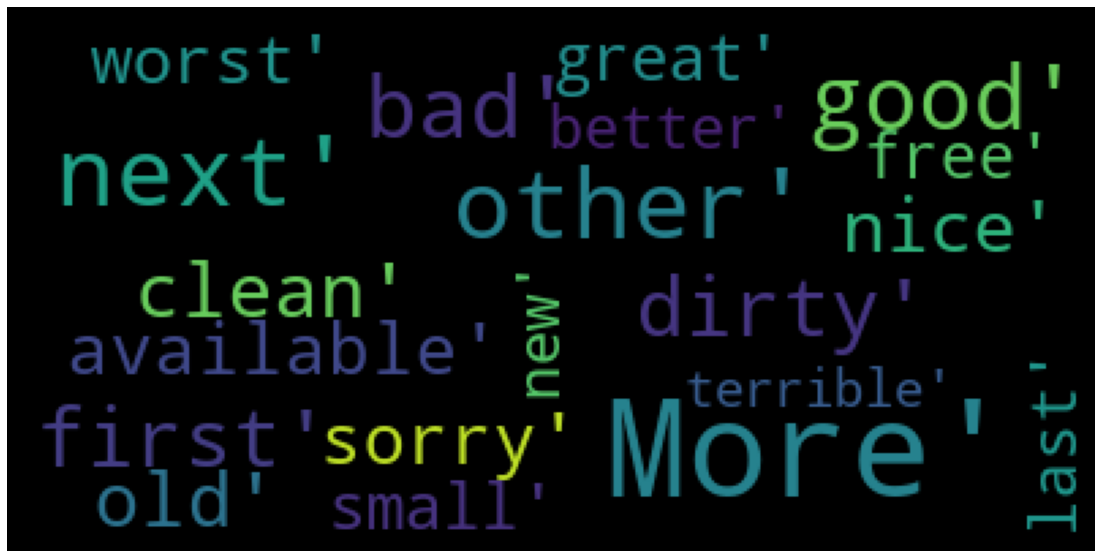

In [11]:
## Word cloud showing most used adjectives in 1 star reviews
text = str([word for word,tag in nltk.pos_tag(nltk.word_tokenize(pd.Series(review_df.loc[review_df['reviews.rating'] == 1, 'reviews.text']).str.cat(sep=' ')), tagset='universal') if tag == 'ADJ'])

wordcloud = WordCloud(max_words=20, max_font_size=50, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Using data that has been very basically pre-processed (picking out only the adjectives), we can start to see the words that are most important in the 5 and 1 star reviews. This begins to give a good idea on what words will be weighted during the model to classify the review into ratings categories.

#### Graphic Analysis

##### &emsp;Early analysis shows that we have a lot more 'good' reviews than 'bad' ones, which will need to be accounted for when attempting to build a classification model. The heatmap and state histogram show that we have more reviews from certain areas of the United States, particularly California. If trying to encode and use the state column for classification, the number of total reviews from each state will also need to be equalized to ensure fairness in the model. Preliminary results from separating the adjectives in the reviews give a good idea of the words used most in both the best and worst reviews. The crossover in words between the two alludes to the fact that phrases will need to be tokenized, as well as words (i.e. 'clean' is in the word cloud for the worst reviews, which leads me to believe the reviews are actually saying 'not clean' or 'need clean', etc.).

### Milestone 2: Data Preparation

//// ALREADY COMPLETED \\\\\\\
- review_df_2 = .drop(['reviews.dateAdded'], axis=1)
- review_df = pd.concat([review_df_1, review_df_2])
    .drop(['id', 'reviews.dateSeen', 'dateAdded', 'dateUpdated', 'reviews.sourceURLs', 'reviews.userCity', 'reviews.userProvince','reviews.username', 'sourceURLs', 'websites', 'categories', 'primaryCategories', 'address', 'keys'],axis=1)
    .drop_duplicates()
- review_df['reviews.rating'] = review_df['reviews.rating'].apply(lambda x: round(x))
- other_review_df['Rating'] = other_review_df['Rating'].apply(lambda x: round(x))
- review_df['year'] = review_df['reviews.date'].str[0:4].astype(int)

The two data frames were combined (each from different segments of time) and any duplicates dropped. I also dropped all unnecessary columns, since we are only concerned with the rating and the text data for the initial classification model. Dummy variables were created for the reviews rating for the final classification target. From here, I will be using different methods for pre-processing the reviews text depending on which model/pipeline the data will be fed to. (custom classification, GPT-3, BERT, etc.)

In [12]:
## Down sample for classification balance
before = review_df.groupby(['reviews.rating']).size().reset_index().set_axis(['rating', 'count_before'], axis=1)

min = review_df['reviews.rating'].value_counts().min()
review_df = review_df.groupby(['reviews.rating']).apply(lambda x: x.sample(min)).reset_index(drop=True)

after = review_df.groupby(['reviews.rating']).size().reset_index().set_axis(['rating', 'count_after'], axis=1)

diff = before.merge(after, how='left', on='rating')[['rating', 'count_before', 'count_after']]
diff['change'] = diff.apply(lambda row: row['count_after'] - row['count_before'], axis=1)
print(diff.to_string(index=False))

rating  count_before  count_after  change
     1          1134         1134       0
     2          1148         1134     -14
     3          2490         1134   -1356
     4          5568         1134   -4434
     5          9406         1134   -8272


In [13]:
## PREPROCESSING
## Load stop words for function
review_old_df = review_df.copy()
review_df = review_df[['reviews.text', 'reviews.rating']]
review_df['reviews.text'] = review_df['reviews.text'].astype(str)
stop_words = stopwords.words('english')

## Function to remove stopwords and rejoin to string
def remove_stopwords(x):
    string = ' '.join(word for word in x.split() if word not in stop_words and len(x) > 2)
    return string

## Function to remove html tags and rejoin to string
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

## Function to stem words and rejoin to string
def stem_words(text):
    porter = PorterStemmer()
    stemmed = ' '.join([porter.stem(word) for word in text.split()])
    return stemmed

## Take reviews, strip, make lower, replace non-alphanumeric, remove stop words, replace line breaks, remove html tags
review_df['reviews.text'] = review_df['reviews.text'].str.strip().str.lower().apply(lambda x: " ".join(re.findall('[\w]+', x))).\
    apply(lambda x: remove_stopwords(x)).replace(r'br ', '').replace(r'\r','').replace(r'\n', '').apply(lambda x: remove_html_tags(x))

## Stem words using NLTK porter stemmer
review_df['reviews.text'] = review_df['reviews.text'].apply(lambda x: stem_words(x))

In [14]:
## Split datasets
training_review_df = review_df.sample(frac=0.8)
test_review_df = review_df.drop(training_review_df.index)

In [15]:
## TFIDF Vectorizer for manual models
vectorizer_word = TfidfVectorizer(analyzer='word', tokenizer=None, preprocessor=None, stop_words=None,
                                  max_features=2000, ngram_range=(1, 3), dtype=np.float32)
vectorizer_char = TfidfVectorizer(analyzer='char', tokenizer=None, preprocessor=None, stop_words=None,
                                  max_features=4000, ngram_range=(3, 6), dtype=np.float32)

train_feat_word = vectorizer_word.fit_transform(training_review_df['reviews.text'])
test_feat_word = vectorizer_word.transform(test_review_df['reviews.text'])
train_feat_char = vectorizer_char.fit_transform(training_review_df['reviews.text'])
test_feat_char = vectorizer_char.transform(test_review_df['reviews.text'])

In [16]:
## Create train and test variables for models
review_x_train = scipy.sparse.hstack([train_feat_word, train_feat_char])
review_x_test = scipy.sparse.hstack([test_feat_word, test_feat_char])

x_train = training_review_df['reviews.text']
x_test = test_review_df['reviews.text']

y_train = training_review_df['reviews.rating']
y_test = test_review_df['reviews.rating']

### Milestone 3: Building Models

#### TFIDF Data

In [17]:
## Build pipeline to find 'best' model/hyperparameter combo
pipeline = Pipeline([('classifier', rfc())])

## Compile search space
## Random forest, logistic regression, multinomial naive bayes, and linear support vectors can handle multi-class text classfication
search_space = [{'classifier' : [rfc(n_jobs=-1)], 'classifier__n_estimators' : [10, 100, 1000, 10000], 'classifier__criterion' : ['gini' ,'entropy']},
                {'classifier' : [lr(multi_class='multinomial', max_iter=10000000, random_state=1)], 'classifier__solver' : ['newton-cg', 'lbfgs', 'sag' ,'saga'], 'classifier__penalty' : ['l1', 'l2', 'elasticnet']},
                {'classifier' : [mnb()], 'classifier__alpha' : [0, 1], 'classifier__fit_prior': [True, False]},
                {'classifier' : [lsvc(max_iter=10000000)], 'classifier__penalty' : ['l1', 'l2'], 'classifier__multi_class' : ['ovr', 'crammer_singer']}]

## Use GridSearch with pipeline and search space to attempt all combinations
classifier = GridSearchCV(pipeline, search_space, cv=5, verbose=0)

## Fit the training data to the grid search
classifier.fit(review_x_train,y_train)

C:\Users\michaelzoucha\Miniconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\michaelzoucha\Miniconda3\

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [RandomForestClassifier(n_jobs=-1)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__n_estimators': [10, 100, 1000, 10000]},
                         {'classifier': [LogisticRegression(max_iter=10000000,
                                                            multi_class='multinomial',
                                                            random_state=1,
                                                            solver='newton-cg')],
                          'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                          'classifier__solver': ['newton-cg', 'lbfgs', 'sag',
                                                 'saga']},
                         {'classifier': [MultinomialNB()],
                          'classi

In [18]:
## Print statistics on best model
print("Best Score: " + str(classifier.best_score_))
print('Best Estimator' + str(classifier.best_estimator_))
print('Best Parameters: ' + str(classifier.best_params_))

Best Score: 0.486989834328206
Best EstimatorPipeline(steps=[('classifier',
                 LogisticRegression(max_iter=10000000,
                                    multi_class='multinomial', random_state=1,
                                    solver='newton-cg'))])
Best Parameters: {'classifier': LogisticRegression(max_iter=10000000, multi_class='multinomial', random_state=1,
                   solver='newton-cg'), 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


In [19]:
## Print results of all combinations
pd.DataFrame(classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__n_estimators,param_classifier__penalty,param_classifier__solver,param_classifier__alpha,...,param_classifier__multi_class,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.613094,0.256732,0.004802,0.000427,RandomForestClassifier(n_jobs=-1),gini,10,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.361233,0.348401,0.332966,0.361632,0.337376,0.348322,0.011828,20
1,0.707796,0.086797,0.018341,0.002038,RandomForestClassifier(n_jobs=-1),gini,100,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.435022,0.402426,0.420066,0.435502,0.453142,0.429232,0.017013,17
2,4.603715,0.169453,0.150908,0.018752,RandomForestClassifier(n_jobs=-1),gini,1000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.435022,0.433297,0.417861,0.446527,0.429989,0.432539,0.009212,15
3,43.046912,0.587915,4.361508,0.206811,RandomForestClassifier(n_jobs=-1),gini,10000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.444934,0.437707,0.431092,0.449835,0.460860,0.444885,0.010213,10
4,0.421379,0.079430,0.005012,0.000039,RandomForestClassifier(n_jobs=-1),entropy,10,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.341410,0.372657,0.342889,0.379272,0.359427,0.359131,0.015275,19
5,0.792184,0.052376,0.019909,0.001733,RandomForestClassifier(n_jobs=-1),entropy,100,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.429515,0.411246,0.420066,0.452040,0.422271,0.427028,0.013798,18
6,5.494683,0.112307,0.184753,0.011394,RandomForestClassifier(n_jobs=-1),entropy,1000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.430617,0.423374,0.414553,0.444322,0.437707,0.430115,0.010463,16
7,52.706574,0.450833,4.556089,0.272387,RandomForestClassifier(n_jobs=-1),entropy,10000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.439427,0.426681,0.422271,0.450937,0.436604,0.435184,0.010072,14
8,0.004026,0.000599,0.000000,0.000000,"LogisticRegression(max_iter=10000000, multi_cl...",NaN,NaN,l1,newton-cg,NaN,...,NaN,{'classifier': LogisticRegression(max_iter=100...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
9,0.004005,0.000631,0.000000,0.000000,"LogisticRegression(max_iter=10000000, multi_cl...",NaN,NaN,l1,lbfgs,NaN,...,NaN,{'classifier': LogisticRegression(max_iter=100...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22


Accuracy: 51.23%
Precision: 0.51
Recall: 0.51
F1 score: 0.51

              precision    recall  f1-score   support

           1       0.60      0.65      0.62       224
           2       0.41      0.44      0.43       221
           3       0.46      0.42      0.44       234
           4       0.49      0.43      0.46       235
           5       0.59      0.63      0.61       220

    accuracy                           0.51      1134
   macro avg       0.51      0.51      0.51      1134
weighted avg       0.51      0.51      0.51      1134



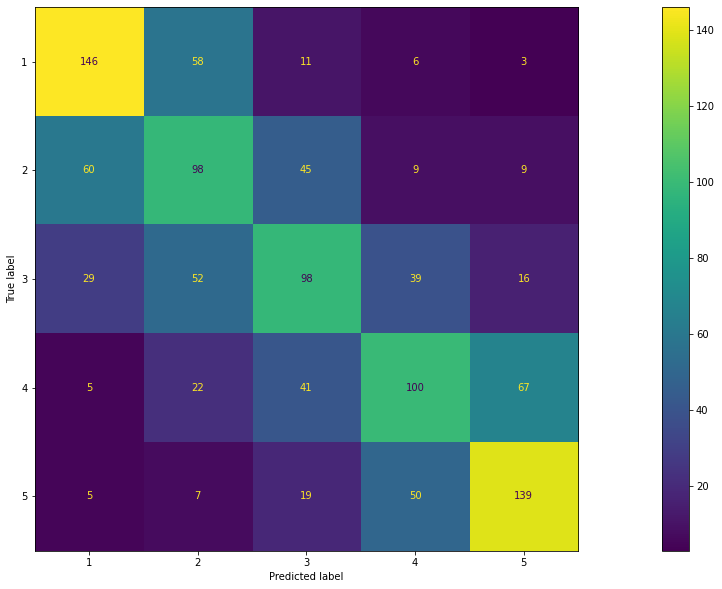

In [20]:
## Make predictions with best model from GridSearchCV
pred = classifier.predict(review_x_test)

## Calculate and print stats
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='micro')
recall = recall_score(y_test, pred, average='micro')
f1 = f1_score(y_test, pred, average='micro')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}" + '\n')

## Print classification report
print(metrics.classification_report(y_test, pred))

## Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, pred, labels=classifier.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classifier.classes_)
disp.plot()
plt.show()

##### Neural Network (Keras Tokenizer)

In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7902490935963705621
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22729785344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 678734236853932082
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [ ]:
## Build model with Keras tokenizer
## Constants
vocab_size = 50000
embedding_dim = 128
max_length = 200

# Truncation and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

## Split text and ratings
text_train = training_review_df["reviews.text"].values
rating_train = training_review_df[["reviews.rating"]].values
text_test = test_review_df["reviews.text"].values
rating_test = test_review_df[["reviews.rating"]].values

## Initialize tokenizer from Keras
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index

## Tokenize and pad token sequences for train and test data
train_seq = tokenizer.texts_to_sequences(text_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_seq = tokenizer.texts_to_sequences(text_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Encode target labels to array
encode = OneHotEncoder()
training_labels = encode.fit_transform(rating_train).todense()
test_labels = encode.transform(rating_test).todense()

## Initialize sequential model
model = Sequential()

## Embedding layer
model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

##Conv1D and GlobalMaxPooling1D layers (text data is 1 dimensional)
model.add(keras.layers.Conv1D(48, 5, activation='relu', padding='valid'))
model.add(keras.layers.GlobalMaxPooling1D())

## Dropout layer
model.add(Dropout(0.5))

## Flatten layer
model.add(Flatten())

## Dropout layer
model.add(Dropout(0.5))

## Dense layer
model.add(Dense(5, activation='softmax'))

## Compile the model with categorical_crossentropy for loss and ADAM for optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Epochs and batch size
epochs = 100
batch_size = 128

## Fit the model
history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size)

Epoch 1/100


Accuracy: 43.12%
Precision: 0.43
Recall: 0.43
F1 score: 0.43

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       224
           1       0.40      0.39      0.39       221
           2       0.31      0.31      0.31       234
           3       0.40      0.41      0.41       235
           4       0.48      0.46      0.47       220

    accuracy                           0.43      1134
   macro avg       0.43      0.43      0.43      1134
weighted avg       0.43      0.43      0.43      1134



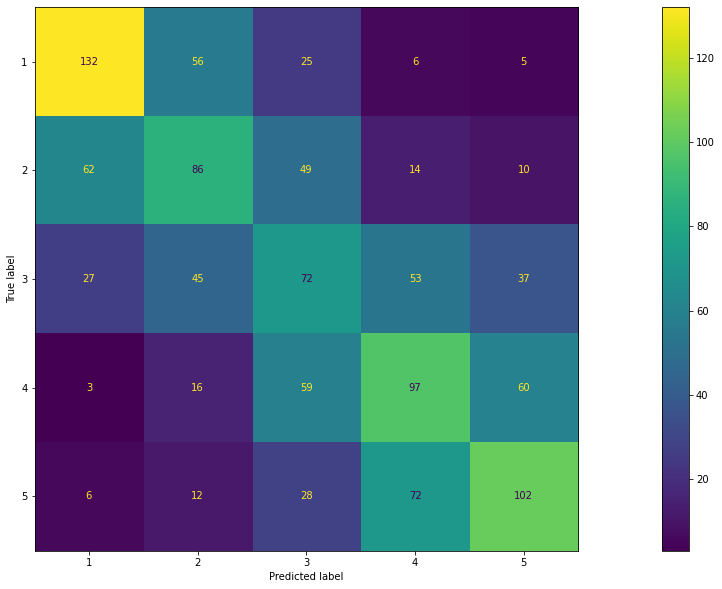

In [22]:
## Predict test values for confusion matrix
pred2 = model.predict(test_padded, batch_size=1)

## Argmax values for confusion matrix
y_true = np.argmax(test_labels, axis=1)
y_preds = np.argmax(pred2, axis=1)

## Calculate and print stats
accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds, average='micro')
recall = recall_score(y_true, y_preds, average='micro')
f1 = f1_score(y_true, y_preds, average='micro')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}" + '\n')

## Print classification report
print(metrics.classification_report(y_true, y_preds))

## Visualize confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[1,2,3,4,5])
disp.plot()
plt.show()

## Grouping Ratings by "Good" (4 or 5) or "Bad" (1 or 2)

In [23]:
## Group ratings by 1-2 and 4-5, then drop the 3 star reviews
review_df['sentiment'] = review_df['reviews.rating'].apply(lambda x: 0 if int(x) < 3 else (1 if int(x) > 3 else 9))
review_df = review_df[review_df.sentiment != 9]

## Split datasets
training_review_df = review_df.sample(frac=0.8)
test_review_df = review_df.drop(training_review_df.index)

In [24]:
## TFIDF Vectorizer for manual models - Use from previous fit()
train_feat_word = vectorizer_word.transform(training_review_df['reviews.text'])
test_feat_word = vectorizer_word.transform(test_review_df['reviews.text'])
train_feat_char = vectorizer_char.transform(training_review_df['reviews.text'])
test_feat_char = vectorizer_char.transform(test_review_df['reviews.text'])

## Create train and test variables for models
review_x_train = scipy.sparse.hstack([train_feat_word, train_feat_char])
review_x_test = scipy.sparse.hstack([test_feat_word, test_feat_char])

x_train = training_review_df['reviews.text']
x_test = test_review_df['reviews.text']

y_train = training_review_df['sentiment']
y_test = test_review_df['sentiment']

In [25]:
## Build pipeline to find 'best' model/hyperparameter combo
pipeline = Pipeline([('classifier', rfc())])

## Compile search space
## Random forest, logistic regression, multinomial naive bayes, and linear support vectors can handle multi-class text classfication
search_space = [{'classifier': [rfc(n_jobs=-1)], 'classifier__n_estimators': [10, 100, 1000, 10000],
                 'classifier__criterion': ['gini', 'entropy']},
                {'classifier': [lr(multi_class='multinomial', max_iter=10000000, random_state=1)],
                 'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                 'classifier__penalty': ['l1', 'l2', 'elasticnet']},
                {'classifier': [mnb()], 'classifier__alpha': [0, 1], 'classifier__fit_prior': [True, False]},
                {'classifier': [lsvc(max_iter=10000000)], 'classifier__penalty': ['l1', 'l2'],
                 'classifier__multi_class': ['ovr', 'crammer_singer']}]

## Use GridSearch with pipeline and search space to attempt all combinations
classifier = GridSearchCV(pipeline, search_space, cv=5, verbose=0)

## Fit the training data to the grid search
classifier.fit(review_x_train, y_train)

C:\Users\michaelzoucha\Miniconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\michaelzoucha\Miniconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\michaelzoucha\Miniconda3\

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [RandomForestClassifier(n_jobs=-1)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__n_estimators': [10, 100, 1000, 10000]},
                         {'classifier': [LogisticRegression(max_iter=10000000,
                                                            multi_class='multinomial',
                                                            random_state=1,
                                                            solver='newton-cg')],
                          'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                          'classifier__solver': ['newton-cg', 'lbfgs', 'sag',
                                                 'saga']},
                         {'classifier': [MultinomialNB()],
                          'classi

In [26]:
## Print statistics on best model
print("Best Score: " + str(classifier.best_score_))
print('Best Estimator' + str(classifier.best_estimator_))
print('Best Parameters: ' + str(classifier.best_params_))

Best Score: 0.8972125011874228
Best EstimatorPipeline(steps=[('classifier',
                 LogisticRegression(max_iter=10000000,
                                    multi_class='multinomial', random_state=1,
                                    solver='newton-cg'))])
Best Parameters: {'classifier': LogisticRegression(max_iter=10000000, multi_class='multinomial', random_state=1,
                   solver='newton-cg'), 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


In [27]:
## Print results of all combinations
pd.DataFrame(classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__n_estimators,param_classifier__penalty,param_classifier__solver,param_classifier__alpha,...,param_classifier__multi_class,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.224306,0.005052,0.005120,0.000579,RandomForestClassifier(n_jobs=-1),gini,10,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.825069,0.801653,0.848485,0.827824,0.794483,0.819503,0.019415,19
1,0.445388,0.095659,0.016686,0.001426,RandomForestClassifier(n_jobs=-1),gini,100,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.855372,0.841598,0.873278,0.867769,0.831724,0.853948,0.015576,17
2,2.096159,0.085968,0.116469,0.006638,RandomForestClassifier(n_jobs=-1),gini,1000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.865014,0.852617,0.867769,0.871901,0.830345,0.857529,0.015037,16
3,18.262954,0.502041,1.089241,0.023977,RandomForestClassifier(n_jobs=-1),gini,10000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.866391,0.841598,0.867769,0.877410,0.834483,0.857530,0.016514,15
4,0.245072,0.045109,0.006005,0.002109,RandomForestClassifier(n_jobs=-1),entropy,10,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.818182,0.808540,0.825069,0.820937,0.809655,0.816476,0.006421,20
5,0.483601,0.088633,0.016258,0.000764,RandomForestClassifier(n_jobs=-1),entropy,100,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.859504,0.838843,0.865014,0.876033,0.826207,0.853120,0.018085,18
6,2.189651,0.082808,0.104722,0.006525,RandomForestClassifier(n_jobs=-1),entropy,1000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.859504,0.848485,0.866391,0.880165,0.840000,0.858909,0.013960,14
7,19.622773,0.456724,1.110284,0.054795,RandomForestClassifier(n_jobs=-1),entropy,10000,NaN,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.863636,0.853994,0.867769,0.881543,0.833103,0.860009,0.016107,13
8,0.003211,0.000442,0.000000,0.000000,"LogisticRegression(max_iter=10000000, multi_cl...",NaN,NaN,l1,newton-cg,NaN,...,NaN,{'classifier': LogisticRegression(max_iter=100...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
9,0.002866,0.000445,0.000000,0.000000,"LogisticRegression(max_iter=10000000, multi_cl...",NaN,NaN,l1,lbfgs,NaN,...,NaN,{'classifier': LogisticRegression(max_iter=100...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26


Accuracy: 89.86%
Precision: 0.90
Recall: 0.90
F1 score: 0.90

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       444
           1       0.90      0.91      0.90       463

    accuracy                           0.90       907
   macro avg       0.90      0.90      0.90       907
weighted avg       0.90      0.90      0.90       907



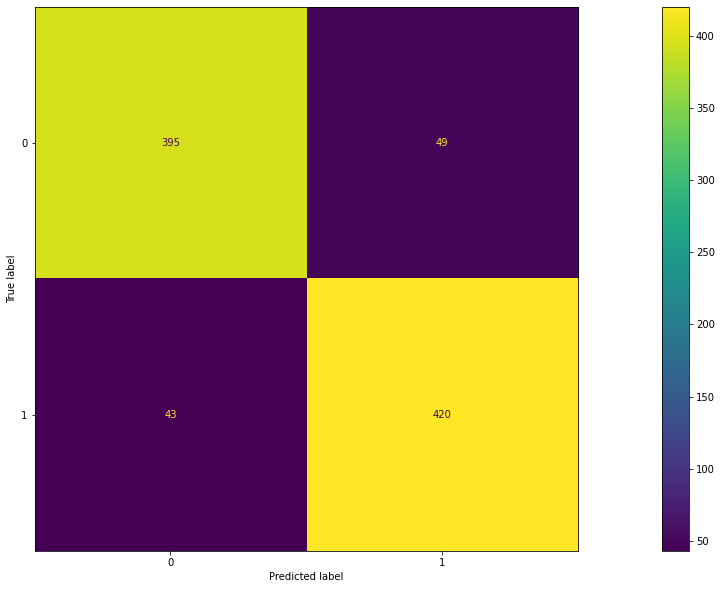

In [28]:
## Make predictions with best model from GridSearchCV
pred = classifier.predict(review_x_test)

## Calculate and print stats
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='micro')
recall = recall_score(y_test, pred, average='micro')
f1 = f1_score(y_test, pred, average='micro')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}" + '\n')

## Print classification report
print(metrics.classification_report(y_test, pred))

## Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, pred, labels=classifier.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [29]:
## Build model with Keras tokenizer
## Constants
vocab_size = 50000
embedding_dim = 128
max_length = 200

# Truncation and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

## Split text and ratings
text_train = training_review_df["reviews.text"].values
rating_train = training_review_df[["sentiment"]].values
text_test = test_review_df["reviews.text"].values
rating_test = test_review_df[["sentiment"]].values

## Initialize tokenizer from Keras
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index

## Tokenize and pad token sequences for train and test data
train_seq = tokenizer.texts_to_sequences(text_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_seq = tokenizer.texts_to_sequences(text_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Encode target labels to array
encode = OneHotEncoder()
training_labels = encode.fit_transform(rating_train).todense()
test_labels = encode.transform(rating_test).todense()

## Initialize sequential model
model = Sequential()

## Embedding layer
model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

##Conv1D and GlobalMaxPooling1D layers (text data is 1 dimensional)
model.add(keras.layers.Conv1D(48, 5, activation='relu', padding='valid'))
model.add(keras.layers.GlobalMaxPooling1D())

## Dropout layer
model.add(Dropout(0.5))

## Flatten layer
model.add(Flatten())

## Dropout layer
model.add(Dropout(0.5))

## Dense layer
model.add(Dense(2, activation='softmax'))

## Compile the model with categorical_crossentropy for loss and ADAM for optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Epochs and batch size
epochs = 100
batch_size = 128

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          6400000   
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 48)           30768     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 48)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 48)                0         
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dropout_3 (Dropout)         (None, 48)                0         
                                                      

In [30]:
## Fit the model
history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size)

Epoch 1/100
29/29 [==============================] - 1s 44ms/step - loss: 0.6804 - accuracy: 0.5671
Epoch 2/100
29/29 [==============================] - 1s 44ms/step - loss: 0.5984 - accuracy: 0.7266
Epoch 3/100
29/29 [==============================] - 1s 45ms/step - loss: 0.4758 - accuracy: 0.8190
Epoch 4/100
29/29 [==============================] - 1s 51ms/step - loss: 0.3725 - accuracy: 0.8625
Epoch 5/100
29/29 [==============================] - 1s 46ms/step - loss: 0.2923 - accuracy: 0.8986
Epoch 6/100
29/29 [==============================] - 1s 42ms/step - loss: 0.2313 - accuracy: 0.9226
Epoch 7/100
29/29 [==============================] - 1s 50ms/step - loss: 0.1953 - accuracy: 0.9363
Epoch 8/100
29/29 [==============================] - 1s 43ms/step - loss: 0.1557 - accuracy: 0.9510
Epoch 9/100
29/29 [==============================] - 1s 45ms/step - loss: 0.1362 - accuracy: 0.9595
Epoch 10/100
29/29 [==============================] - 1s 52ms/step - loss: 0.1266 - accuracy: 0.9656

Accuracy: 83.02%
Precision: 0.83
Recall: 0.83
F1 score: 0.83

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       444
           1       0.84      0.82      0.83       463

    accuracy                           0.83       907
   macro avg       0.83      0.83      0.83       907
weighted avg       0.83      0.83      0.83       907



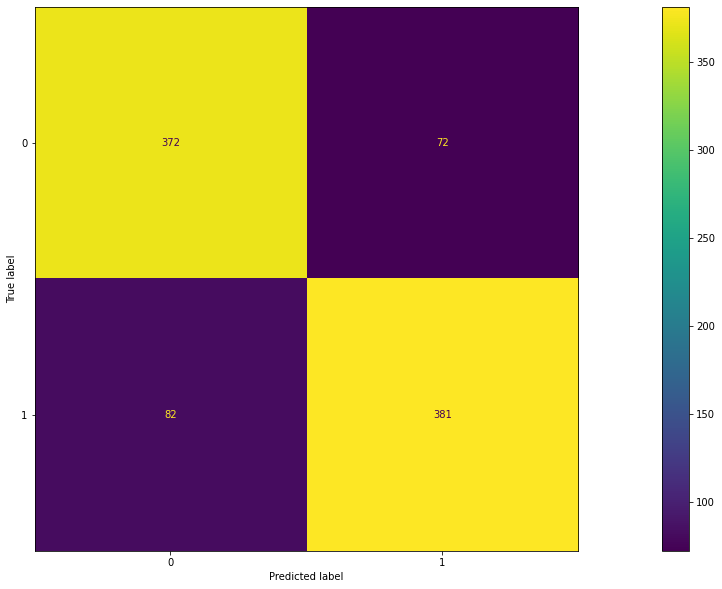

In [31]:
## Predict test values for confusion matrix
pred2 = model.predict(test_padded, batch_size=1)

## Argmax values for confusion matrix
y_true = np.argmax(test_labels, axis=1)
y_preds = np.argmax(pred2, axis=1)

## Calculate and print stats
accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds, average='micro')
recall = recall_score(y_true, y_preds, average='micro')
f1 = f1_score(y_true, y_preds, average='micro')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}" + '\n')

## Print classification report
print(metrics.classification_report(y_true, y_preds))

## Visualize confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1])
disp.plot()
plt.show()

## Test Models on Second Dataset

In [32]:
## PREPROCESSING
## Load stop words for function
other_review_df['Review'] = other_review_df['Review'].astype(str)

## Function to remove stopwords and rejoin to string
def remove_stopwords(x):
    string = ' '.join(word for word in x.split() if word not in stop_words and len(x) > 2)
    return string

## Function to remove html tags and rejoin to string
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

## Function to stem words and rejoin to string
def stem_words(text):
    porter = PorterStemmer()
    stemmed = ' '.join([porter.stem(word) for word in text.split()])
    return stemmed

## Take reviews, strip, make lower, replace non-alphanumeric, remove stop words, replace line breaks, remove html tags
other_review_df['Review'] = other_review_df['Review'].str.strip().str.lower().apply(lambda x: " ".join(re.findall('[\w]+', x)))\
    .apply(lambda x: remove_stopwords(x)).replace(r'br ', '').replace(r'\r','').replace(r'\n', '').apply(lambda x: remove_html_tags(x))

## Stem words using NLTK porter stemmer
other_review_df['Review'] = other_review_df['Review'].apply(lambda x: stem_words(x))

In [33]:
## Group ratings by 1-2 and 4-5
other_review_df['sentiment'] = other_review_df['Rating'].apply(lambda x: 0 if int(x) < 3 else (1 if int(x) > 3 else 9))

## TFIDF Vectorizer for manual models - Use from previous fit()
other_train_feat_word = vectorizer_word.transform(other_review_df['Review'])
other_train_feat_char = vectorizer_char.transform(other_review_df['Review'])

## Create train and test variables for models
other_review_x = scipy.sparse.hstack([other_train_feat_word, other_train_feat_char])

other_x = other_review_df['Review']

other_y = other_review_df['sentiment']

In [34]:
## Make predictions with best model from GridSearchCV
other_pred = classifier.predict(other_review_x)

other_review_results = other_review_df.copy()

other_review_results['classifier'] = other_pred

other_review_results['accuracy'] = other_review_results.apply(lambda x: 1 if (x['sentiment'] == x['classifier'] and x['sentiment'] < 9) else 0, axis=1)
other_review_results['mids'] = other_review_results.apply(lambda x: 1 if (x['sentiment'] == 9 and x['classifier'] == 1) else 0, axis=1)

accuracy = other_review_results['accuracy'].sum() / len(other_review_results[other_review_results.sentiment != 9])
threes = other_review_results['mids'].sum() / len(other_review_results[other_review_results.sentiment == 9])

print('Good/Bad Accuracy: ' + str(round((accuracy * 100), 2)) + '%')
print('\n3-star Reviews:')
print('Classified as "Good": ' + str(round((threes * 100), 2)) + '%')
print('Classified as "Bad": ' + str(round(((1-threes) * 100), 2)) + '%')

Good/Bad Accuracy: 93.41%

3-star Reviews:
Classified as "Good": 68.73%
Classified as "Bad": 31.27%


In [35]:
## Split text and ratings
other_text = other_review_df["Review"].values
other_rating = other_review_df[["sentiment"]].values

## Tokenize and pad token sequences for train and test data
train_seq = tokenizer.texts_to_sequences(other_x)
other_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Predict test values for confusion matrix
other_pred2 = model.predict(other_padded, batch_size=1)
other_y_preds = np.argmax(other_pred2, axis=1)

other_review_results = other_review_df.copy()

other_review_results['classifier'] = other_y_preds

other_review_results['accuracy'] = other_review_results.apply(lambda x: 1 if (x['sentiment'] == x['classifier'] and x['sentiment'] < 9) else 0, axis=1)
other_review_results['mids'] = other_review_results.apply(lambda x: 1 if (x['sentiment'] == 9 and x['classifier'] == 1) else 0, axis=1)

accuracy = other_review_results['accuracy'].sum() / len(other_review_results[other_review_results.sentiment != 9])
threes = other_review_results['mids'].sum() / len(other_review_results[other_review_results.sentiment == 9])

print('Good/Bad Accuracy: ' + str(round((accuracy * 100), 2)) + '%')

print('\n3-star Reviews:')
print('Classified as "Good": ' + str(round((threes * 100), 2)) + '%')
print('Classified as "Bad": ' + str(round(((1-threes) * 100), 2)) + '%')

Good/Bad Accuracy: 73.42%

3-star Reviews:
Classified as "Good": 39.79%
Classified as "Bad": 60.21%


#### Model Analysis

##### &emsp;As we can clearly see from the models above, the closeness of the reviews' ratings (labeled by the user themselves) made it very difficult for the models to accurately distinguish reviews from those in close, but different, rating categories (e.g. distinguishing 4 star from 3 or 5 star reviews). I believe this is due to the subjective nature of online reviews and the labels they are given by the user. One person's 3-star review is another's 5-star or 1-star review. I was pleased the model didn't have too difficult of a time distinguishing between the 5-star and 1- or 2-star reviews, or the 1-star from the 4- or 5-star reviews. This lead to me changing my strategy for modelling the reviews.

##### &emsp;By grouping the reviews by 'good' (4- and 5-star reviews) and 'bad' (1- and 2-star reviews) and dropping the 3-star reviews, I was able to double every performance metric of the models, including accuracy and precision. From a business perspective, this model is about quickly discovering, escalating, and handling the 'bad' text data that comes through in different channels, so I now believe classifying the individual 'star' rating is of less value. This model is now able to predict the binary category of 'good vs bad' much more quickly, and accurately,than I was ever able to get otherwise, regardless of the amount of tuning I did, or layers I added to a neural network.